In [1]:
import pandas as pd
import nltk
import numpy as np
import re

#load inthe NTLK stopwords to remove articles, preposition and other words that are not actionable
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
# Lemmatizer helps to reduce words to the base form
from nltk.stem import WordNetLemmatizer

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os
os.chdir('/content/gdrive/My Drive/Deep Learning/Code')
df=pd.read_csv('summer-products-with-rating-and-performance_2020-08.csv')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

Mounted at /content/gdrive


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<ipython-input-3-02460683962f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='high_sale', palette=['blue', 'orange'])


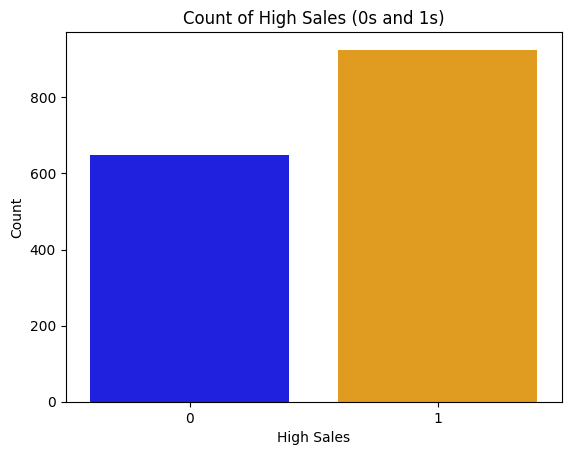

In [3]:
label = [1 if sales > 300 else 0 for sales in df["units_sold"]]
df['high_sale'] = label

# Plotting with Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='high_sale', palette=['blue', 'orange'])
plt.xlabel('High Sales')
plt.ylabel('Count')
plt.title('Count of High Sales (0s and 1s)')
plt.show()

In [4]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['high_sale'] == 1]  # 900 rows
df_minority = df[df['high_sale'] == 0]  # 640 rows

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                               replace=True,
                               n_samples=len(df_majority),
                               random_state=42)

# Combine majority and upsampled minority
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Verify the balance
print("Original dataset shape:", df['high_sale'].value_counts())
print("\nBalanced dataset shape:", df_balanced['high_sale'].value_counts())

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

Original dataset shape: high_sale
1    925
0    648
Name: count, dtype: int64

Balanced dataset shape: high_sale
1    925
0    925
Name: count, dtype: int64


<ipython-input-5-90206697b221>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='high_sale', palette=['blue', 'orange'])


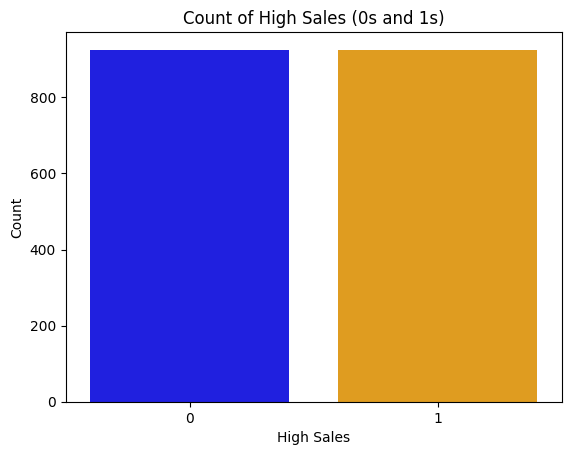

In [5]:
sns.countplot(data=df_balanced, x='high_sale', palette=['blue', 'orange'])
plt.xlabel('High Sales')
plt.ylabel('Count')
plt.title('Count of High Sales (0s and 1s)')
plt.show()

In [6]:
df_balanced = df_balanced[['high_sale', 'title_orig']]

In [7]:
def process_sentence(sentence):
    new_tokens = word_tokenize(sentence)
    new_tokens = [token.lower() for token in new_tokens]
    new_tokens =[token for token in new_tokens if token not in stopwords.words('english')]
    new_tokens = [token for token in new_tokens if token.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(token) for token in new_tokens]
    return " ".join(new_tokens)

In [8]:
titles = df_balanced['title_orig'].tolist()
tokens = [process_sentence(t) for t in titles]
df_balanced['title_preprocessed'] = tokens
df_balanced.head()

,high_sale,title_orig,title_preprocessed
0,1,Women Fashion Casual Summer Sleeveless Blackle...,woman fashion casual summer sleeveless blackle...
1,0,Summer Fashion Women Sexy Lace Strap Shirt Top...,summer fashion woman sexy lace strap shirt top...
2,1,Woman's New Summer Women Stretchy Camisole Sp...,woman new summer woman stretchy camisole spagh...
3,1,Women Fashion Lace Party Cocktail Mini Dress L...,woman fashion lace party cocktail mini dress l...
4,0,Women Summer Off Sholuder Round Neck Printed B...,woman summer sholuder round neck printed big s...


In [9]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   high_sale           1850 non-null   int64 
 1   title_orig          1850 non-null   object
 2   title_preprocessed  1850 non-null   object
dtypes: int64(1), object(2)
memory usage: 43.5+ KB


In [10]:
from transformers import BertTokenizer, TFBertModel
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture 

In [11]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
import numpy as np
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', from_pt=True)
bert_model = TFBertModel.from_pretrained('bert-base-uncased', from_pt=True)

def encode_texts(texts, max_length=128):
    inputs = tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )
    return inputs

def get_bert_embeddings(encoded_inputs):
    outputs = bert_model(encoded_inputs['input_ids'],
                        attention_mask=encoded_inputs['attention_mask'])
    return outputs.last_hidden_state[:, 0, :]

def process_in_batches(df, batch_size=32):
    """Process text data in batches to avoid memory issues"""
    all_embeddings = []

    # Calculate number of batches
    n_samples = len(df)
    n_batches = (n_samples + batch_size - 1) // batch_size

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)

        # Get batch of texts
        batch_texts = df['title_preprocessed'].iloc[start_idx:end_idx]

        # Process batch
        batch_encodings = encode_texts(batch_texts)
        batch_embeddings = get_bert_embeddings(batch_encodings)

        # Convert to numpy and store
        all_embeddings.append(batch_embeddings.numpy())

        # Optional: Print progress
        print(f"Processed batch {i+1}/{n_batches}", end='\r')

    # Combine all batches
    final_embeddings = np.vstack(all_embeddings)
    print("\nProcessing complete!")
    return final_embeddings

# Process data in batches
bert_embeddings_np = process_in_batches(df_balanced, batch_size=32)

print("BERT embeddings shape:", bert_embeddings_np.shape)

# Add embeddings as features
for i in range(bert_embeddings_np.shape[1]):
    df_balanced[f'bert_feature_{i}'] = bert_embeddings_np[:, i]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Processed batch 58/58
Processing complete!
BERT embeddings shape: (1850, 768)


In [12]:
df_balanced.head()

,high_sale,title_orig,title_preprocessed,bert_feature_0,bert_feature_1,bert_feature_2,bert_feature_3,bert_feature_4,bert_feature_5,bert_feature_6,...,bert_feature_758,bert_feature_759,bert_feature_760,bert_feature_761,bert_feature_762,bert_feature_763,bert_feature_764,bert_feature_765,bert_feature_766,bert_feature_767
0,1,Women Fashion Casual Summer Sleeveless Blackle...,woman fashion casual summer sleeveless blackle...,0.001005,-0.533275,-0.534818,0.156759,0.073843,-0.061246,0.418828,...,-0.009219,-0.727769,0.371944,-0.085761,0.138729,-0.245404,-0.088360,-0.366857,0.028042,-0.036503
1,0,Summer Fashion Women Sexy Lace Strap Shirt Top...,summer fashion woman sexy lace strap shirt top...,-0.105362,-0.345659,-0.226914,0.226847,0.053992,0.015522,0.443834,...,-0.013285,-0.728474,0.332205,0.045897,0.000037,-0.168964,-0.067307,-0.257121,0.112011,-0.103263
2,1,Woman's New Summer Women Stretchy Camisole Sp...,woman new summer woman stretchy camisole spagh...,-0.048788,-0.846473,-0.265181,0.217692,0.046021,-0.087229,0.363559,...,0.039934,-0.585656,0.217908,-0.125180,0.248969,-0.192281,0.001998,-0.244936,-0.147212,0.137787
3,1,Women Fashion Lace Party Cocktail Mini Dress L...,woman fashion lace party cocktail mini dress l...,-0.134902,-0.363934,0.069911,0.314845,-0.003409,0.077615,0.735594,...,-0.050925,-0.711547,0.259914,0.183044,0.213245,-0.284517,0.154202,-0.275265,-0.189102,-0.130316
4,0,Women Summer Off Sholuder Round Neck Printed B...,woman summer sholuder round neck printed big s...,-0.146917,-0.475034,-0.028959,0.103094,0.175031,-0.036770,0.392105,...,-0.171903,-0.705456,0.122383,0.211105,0.325868,-0.171740,-0.095418,-0.317080,-0.116700,-0.094603


In [13]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Columns: 771 entries, high_sale to bert_feature_767
dtypes: float32(768), int64(1), object(2)
memory usage: 5.5+ MB


In [14]:
X = df_balanced.loc[:, ~df_balanced.columns.isin(['high_sale', 'title_orig', 'title_preprocessed'])]
y = df_balanced['high_sale']

In [15]:
# Verify shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1850, 768)
y shape: (1850,)


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14286, random_state=42)

In [17]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of val examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1386
number of val examples = 232
number of test examples = 232
X_train shape: (1386, 768)
Y_train shape: (1386,)
X_val shape: (232, 768)
Y_val shape: (232,)
X_test shape: (232, 768)
Y_test shape: (232,)


In [18]:
X_train = tf.expand_dims(X_train, axis=-1)

In [19]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

# Define model
model = Sequential([
    Dense(256, activation='relu',
          kernel_regularizer=l2(0.01),
          input_shape=(768,)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu',
          kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    # Output layer
    Dense(1, activation='sigmoid')
])

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [21]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        min_lr=1e-6
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5020 - loss: 6.4176 - val_accuracy: 0.5172 - val_loss: 6.0181 - learning_rate: 1.0000e-04
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 6.0996 - val_accuracy: 0.5259 - val_loss: 5.8173 - learning_rate: 1.0000e-04
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5665 - loss: 5.8956 - val_accuracy: 0.5216 - val_loss: 5.6364 - learning_rate: 1.0000e-04
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5646 - loss: 5.7202 - val_accuracy: 0.5948 - val_loss: 5.4665 - learning_rate: 1.0000e-04
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6487 - loss: 5.4465 - val_accuracy: 0.6422 - val_loss: 5.2927 - learning_rate: 1.0000e-04
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6374 - loss: 5.3141 - val_accuracy: 0.6853 - val_loss: 5.1443 - learning_rate: 1.0000e-04
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6433

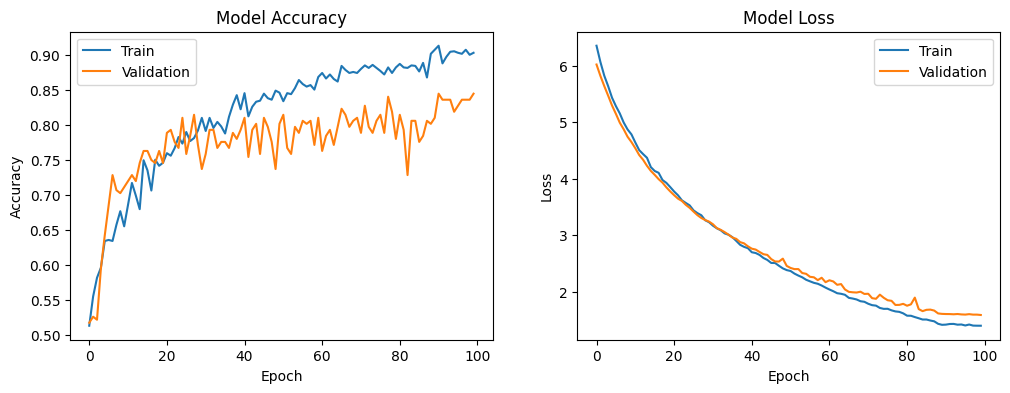

In [22]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import classification_report

# Predict on the test data
y_pred_prob = model.predict([X_test])

# Convert probabilities to binary predictions (threshold 0.5 for sigmoid activation)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.4f}")



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Accuracy on test data: 0.8233
